# import library

In [174]:
import numpy as np
from scipy.io import loadmat
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import math

# split data

In [175]:
Data = loadmat('D.mat')
chan = Data['Channels']
time = Data['Time'][0]
data = Data['Data']
o1 = data[0, :]
o2 = data[1, :]
oz = data[2, :]

#  show data with plot

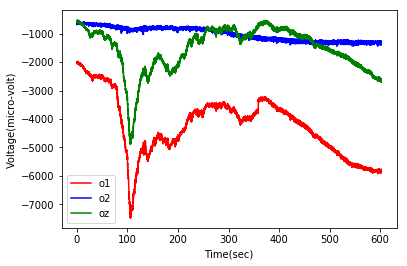

In [176]:
plt.plot(time, o1, 'r')
plt.plot(time, o2, 'b')
plt.plot(time, oz, 'g')
plt.legend(('o1', 'o2', 'oz'))
plt.xlabel('Time(sec)')
plt.ylabel('Voltage(micro-volt)')
plt.show()

# make one signal

In [177]:
AvgOcp = (o1 + o2 + oz) / 3
AvgOcp = AvgOcp - np.mean(AvgOcp)
eye_open = AvgOcp[(time > 0) & (time < 300)]
eye_close = AvgOcp[(time > 300) & (time < 600)]

# use fft function

In [178]:
YOpen = fft(eye_open)
YClose = fft(eye_close)

# make frequence

In [179]:
Fs = 1000
FreqsOpen = np.linspace(-Fs/2, Fs/2, len(YOpen))
FreqsClose = np.linspace(-Fs/2, Fs/2, len(YClose))

YOpen = YOpen[FreqsOpen > 0]
YClose = YClose[FreqsClose > 0] 

FreqsOpen = FreqsOpen[FreqsOpen > 0]
FreqsClose = FreqsClose[FreqsClose > 0]

YOpen = YOpen[::-1]
YClose = YClose[::-1]

YClose[2:] = 2*YClose[2:]
YOpen[2:] = 2*YOpen[2:]

FtClose = abs(YClose) / len(eye_close)
FtOpen = abs(YOpen) / len(eye_open)

FtOpendB = 20 * np.log10(FtOpen)
FtClosedB = 20 * np.log10(FtClose)

# smooth function

In [180]:
def smooth(ls, dg):
    for i in range(dg+1, len(ls)-dg-1):
        ls[i] = ls[i-dg:i+dg].mean()
    return ls

# show  with plot 

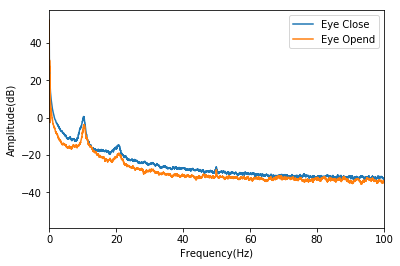

In [181]:
plt.plot(FreqsClose , smooth(FtClosedB,151//2))
plt.plot(FreqsOpen, smooth(FtOpendB, 151//2))
plt.xlim([0, 100])
plt.xlabel('Frequency(Hz)')
plt.ylabel('Amplitude(dB)')
plt.legend(('Eye Close', 'Eye Opend'))
plt.show()

# MyFT function

In [182]:
def MyFT(Signal, Fs):
    MFT = fft(Signal)
    Freq = np.linspace(-Fs/2, Fs/2, len(Signal))
    MFT = MFT[Freq >= 0]
    Freq = Freq[Freq >= 0]
    MFT = MFT[::-1]
    return Freq, (abs(MFT)**2)/ len(Signal)

In [183]:
Fs = 1000
SignalSize = len(AvgOcp)
WindowSize = 1024
JumpSize = WindowSize//4
AvgOcp = (o1 + o2 + oz) / 3

In [184]:
FreqVec = np.linspace(-Fs/2, Fs/2, WindowSize)
nFreqPoints = sum(FreqVec>=0)
nTimePoints = math.ceil((SignalSize-WindowSize)/JumpSize)
TimeVec = (WindowSize/2 + (np.arange(nTimePoints)*JumpSize))/Fs
Power = np.zeros((nFreqPoints, nTimePoints))
StartIdx = 0

for t in range(nTimePoints):
    Window = AvgOcp[StartIdx: WindowSize+StartIdx]
    FreqVec, i_power = MyFT(Window, 1000)
    Power[:, t] = i_power
    StartIdx += JumpSize

In [185]:
ThetaPower = np.mean(Power[(FreqVec>4) & (FreqVec<8)],0)
AlphaPower = np.mean(Power[(FreqVec>8) & (FreqVec<15)],0)

ThetaPowerdB = 10 * np.log10(ThetaPower)
AlphaPowerdB = 10 * np.log10(AlphaPower)

ThetaPowerdBSmoothed = smooth(ThetaPowerdB, 151//2)
AlphaPowerdBSmoothed = smooth(AlphaPowerdB, 151//2)

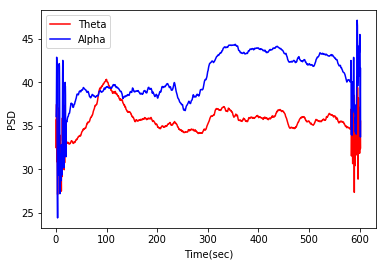

In [186]:
plt.plot(TimeVec,ThetaPowerdBSmoothed,'r')
plt.plot(TimeVec,AlphaPowerdBSmoothed,'b')
plt.legend(('Theta','Alpha'))
plt.xlabel('Time(sec)')
plt.ylabel('PSD')
plt.show()